In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_json = '/kaggle/input/tig-aluminium-5083/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [3]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [4]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1
    
label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [5]:
all_data = []
image_size = (256, 256)
label_count = [0, 0, 0, 0, 0, 0]

In [6]:
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]
                
                if(label_count[label] > 2000):
                    continue
                    
                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = tf.convert_to_tensor(image)
                all_data.append((image, one_hot_encoding[label]))
                
                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [7]:
load_data('/kaggle/input/tig-aluminium-5083/al5083/train')

In [8]:
random.shuffle(all_data)

In [9]:
X = []
y = []

for data in all_data:
    X.append(data[0])
    y.append(data[1])

In [10]:
rand_num = np.random.randint(low = 0, high = len(all_data))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[10, 10, 10, ...,  3,  3,  2],
        [10, 10, 11, ...,  3,  3,  2],
        [10, 10, 11, ...,  3,  3,  2],
        ...,
        [24, 25, 26, ..., 44, 41, 41],
        [25, 25, 25, ..., 41, 40, 41],
        [26, 26, 25, ..., 41, 40, 40]], dtype=uint8)>,
 array([1., 0., 0., 0., 0., 0.], dtype=float32))

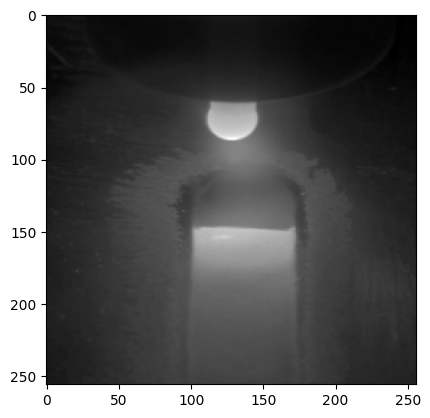

Label : good weld


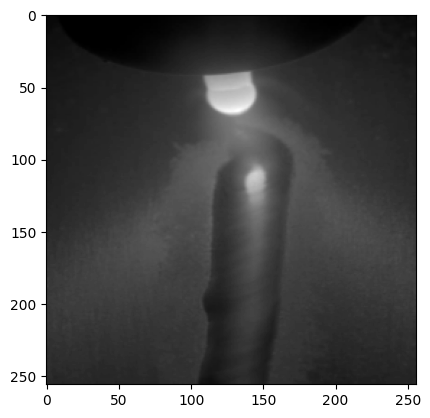

Label : misalignment


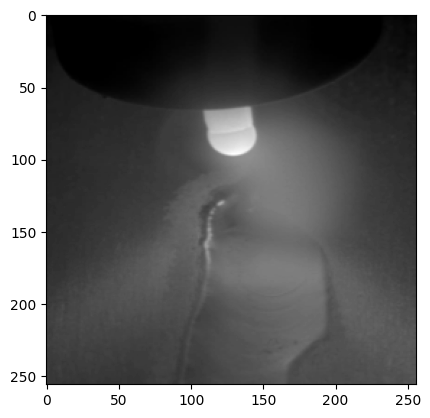

Label : misalignment


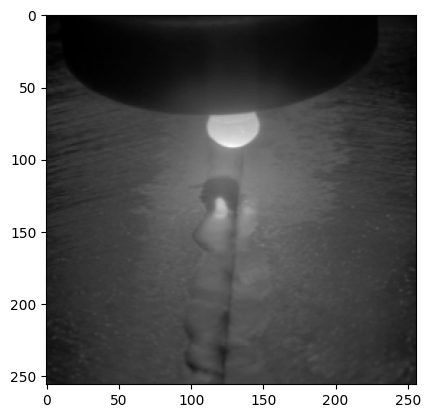

Label : lack of fusion


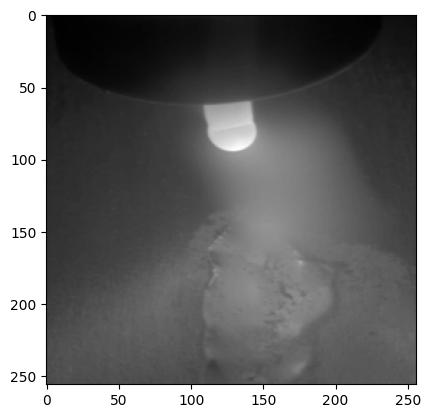

Label : contamination


In [11]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[np.argmax(y[rand_img])]}")

In [12]:
total_data = len(X)
X_train, y_train = X[:int(total_data*0.8)], y[:int(total_data*0.8)]
X_test, y_test = X[int(total_data*0.8):], y[int(total_data*0.8):]

In [13]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([9430, 256, 256]),
 TensorShape([9430, 6]),
 TensorShape([2358, 256, 256]),
 TensorShape([2358, 6]))

In [15]:
X_train = tf.reshape(X_train, shape=(len(X_train), 256, 256, 1))
X_test = tf.reshape(X_test, shape=(len(X_test), 256, 256, 1))

X_train.shape, y_train.shape

(TensorShape([9430, 256, 256, 1]), TensorShape([9430, 6]))

In [16]:
from tensorflow.keras import layers, regularizers

class MyModel(tf.keras.Model):

    def __init__(self, l2_reg=0.01):
        super().__init__()
        self.conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 1), kernel_regularizer=regularizers.l2(l2_reg))
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)
        
        self.conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)
        
        self.conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool5 = layers.MaxPooling2D((2, 2))
        
        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense2 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense3 = layers.Dense(len(labels), activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout3(x)
        
        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        output = self.dense3(x)

        return output


In [17]:
model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [18]:
print(f"Train dataset Size : {len(X_train)}\nTest Dataset size : {len(X_test)}")

Train dataset Size : 9430
Test Dataset size : 2358


In [19]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/model',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [20]:
model.fit(x=X_train, y=y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[callback1])

Epoch 1/25


2024-01-07 11:54:01.057117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmy_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


295/295 [==============================] - ETA: 0s - loss: 10.0289 - accuracy: 0.7946
Epoch 1: val_accuracy improved from -inf to 0.71204, saving model to /model
295/295 [==============================] - 117s 373ms/step - loss: 10.0289 - accuracy: 0.7946 - val_loss: 9.7205 - val_accuracy: 0.7120
Epoch 2/25
295/295 [==============================] - ETA: 0s - loss: 8.8244 - accuracy: 0.9271
Epoch 2: val_accuracy improved from 0.71204 to 0.83757, saving model to /model
295/295 [==============================] - 108s 366ms/step - loss: 8.8244 - accuracy: 0.9271 - val_loss: 8.9305 - val_accuracy: 0.8376
Epoch 3/25
295/295 [==============================] - ETA: 0s - loss: 8.3706 - accuracy: 0.9515
Epoch 3: val_accuracy improved from 0.83757 to 0.88846, saving model to /model
295/295 [==============================] - 108s 368ms/step - loss: 8.3706 - accuracy: 0.9515 - val_loss: 8.3644 - val_accuracy: 0.8885
Epoch 4/25
295/295 [==============================] - ETA: 0s - loss: 7.9575 - acc

In [21]:
model.load_weights('/model')

In [22]:
predictions = model.predict(X_test)

74/74 [==============================] - 3s 35ms/step


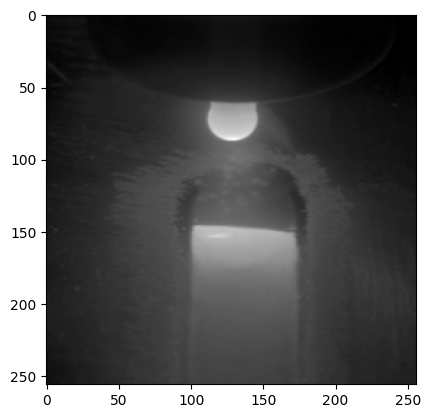

Prediction : good weld
Original : good weld


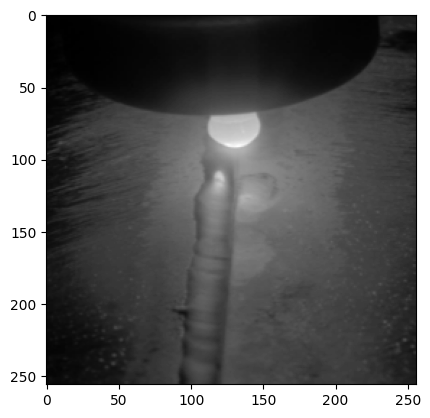

Prediction : lack of fusion
Original : lack of fusion


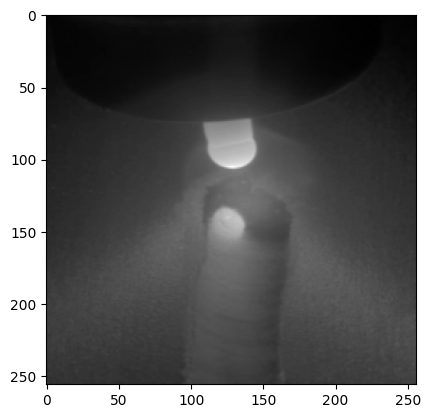

Prediction : lack of penetration
Original : lack of penetration


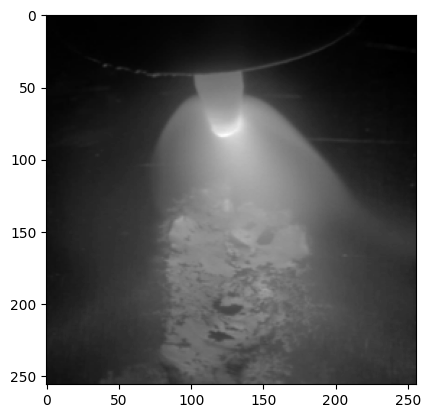

Prediction : contamination
Original : contamination


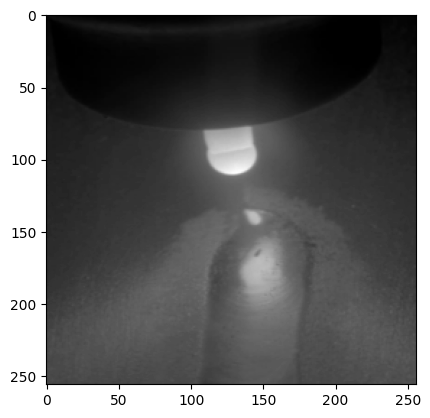

Prediction : lack of penetration
Original : lack of penetration


In [23]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X_test))
    plt.imshow(X_test[rand_img].numpy(), cmap='gray')
    plt.show()
    print(f"Prediction : {label_names[np.argmax(predictions[rand_img])]}")
    print(f"Original : {label_names[np.argmax(y_test[rand_img])]}")

In [24]:
train_metric = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss : {train_metric[0]} , Training Accuracy : {train_metric[1]}")

Training Loss : 3.5529978275299072 , Training Accuracy : 0.998939573764801


In [25]:
test_metric = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss : {test_metric[0]} , Testing Accuracy : {test_metric[1]}")

Testing Loss : 3.555286407470703 , Testing Accuracy : 0.9987277388572693
